## What are we doing in this notebook?

In [61]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc("text", usetex=False)

%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["figure.figsize"] = (8, 6)  #set default figure size
thick_size=16
label_size=20


###EXPLANATION ABOUT BETTING COLUMNS AT      https://www.football-data.co.uk/notes.txt
##FROM https://www.football-data.co.uk/italym.php 
## Fetching data
#Connecting to database
path = "./"  #Insert path here
database = path + 'database.sqlite'
conn = sqlite3.connect(database)


In [62]:
cursor = conn.cursor()

result = cursor.execute("PRAGMA table_info(users)").fetchall()



print("Table schema:")
print(result)

Table schema:
[]


In [63]:
dir(conn)

['DataError',
 'DatabaseError',
 'Error',
 'IntegrityError',
 'InterfaceError',
 'InternalError',
 'NotSupportedError',
 'OperationalError',
 'ProgrammingError',
 'Warning',
 '__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'close',
 'commit',
 'create_aggregate',
 'create_collation',
 'create_function',
 'cursor',
 'enable_load_extension',
 'execute',
 'executemany',
 'executescript',
 'in_transaction',
 'interrupt',
 'isolation_level',
 'iterdump',
 'load_extension',
 'rollback',
 'row_factory',
 'set_authorizer',
 'set_progress_handler',
 'set_trace_callback',
 'text_factory',
 'total_changes']

In [64]:
#####Fetch all tables in sqlite database

sql_query = """SELECT * FROM sqlite_master  WHERE type='table';"""
sql_query = """SELECT * FROM sqlite_master"""
all_tables=pd.read_sql(sql_query, conn)
all_tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,index,sqlite_autoindex_Player_1,Player,15,None
4,index,sqlite_autoindex_Player_2,Player,17,None
5,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
6,index,sqlite_autoindex_Match_1,Match,19,None
7,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
8,index,sqlite_autoindex_League_1,League,25,None
9,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...


In [4]:
pd.read_sql("SELECT * FROM sqlite_sequence;", conn)

,name,seq
0,Team,103916
1,Country,51958
2,League,51958
3,Match,51958
4,Player,11075
5,Player_Attributes,183978
6,Team_Attributes,1458


In [128]:
###Store some tables in separate pandas
country_data = pd.read_sql("SELECT * FROM Country;", conn)
league_data = pd.read_sql("SELECT * FROM League;", conn)
league_data["country_name"]=country_data["name"]
player_data = pd.read_sql("SELECT * FROM Player;", conn)
player_stats_data = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
team_data = pd.read_sql("SELECT * FROM Team ORDER BY team_long_name;", conn)
team_stats_data=pd.read_sql("SELECT * FROM Team_Attributes;", conn)
match_data = pd.read_sql("SELECT * FROM Match;", conn)

###Merge player_name and player_stats tables by calling how="outer"

players_all_data=pd.merge(player_stats_data,player_data,how="outer",on=["player_api_id"])
players_all_data["Date"]=pd.to_datetime(players_all_data.date)
players_all_data["year"]=players_all_data["Date"].apply(lambda x: x.year)



## TIME columns

In [99]:
(pd.to_datetime(player_data.birthday).iloc[0]-pd.Timestamp('1992-01-29'))

Timedelta('31 days 00:00:00')

## NAN VALUES

In [115]:
match_data.columns

Index(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal',
       ...
       'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'],
      dtype='object', length=115)

In [117]:
match_data.VCD

0        3.40
1        3.25
2        3.25
3        3.75
4        3.40
         ... 
25974     NaN
25975     NaN
25976     NaN
25977     NaN
25978     NaN
Name: VCD, Length: 25979, dtype: float64

In [119]:
match_data["VCD"].isna()

0        False
1        False
2        False
3        False
4        False
         ...  
25974     True
25975     True
25976     True
25977     True
25978     True
Name: VCD, Length: 25979, dtype: bool

In [121]:
match_data["VCD"].isnull()

0        False
1        False
2        False
3        False
4        False
         ...  
25974     True
25975     True
25976     True
25977     True
25978     True
Name: VCD, Length: 25979, dtype: bool

In [122]:
match_data["VCD"].notnull()

0         True
1         True
2         True
3         True
4         True
         ...  
25974    False
25975    False
25976    False
25977    False
25978    False
Name: VCD, Length: 25979, dtype: bool

In [136]:
match_data["VCD"].fillna(match_data["VCD"].mean())

0        3.400000
1        3.250000
2        3.250000
3        3.750000
4        3.400000
           ...   
25974    3.899048
25975    3.899048
25976    3.899048
25977    3.899048
25978    3.899048
Name: VCD, Length: 25979, dtype: float64

In [137]:
match_data["VCD"].interpolate()

0        3.40
1        3.25
2        3.25
3        3.75
4        3.40
         ... 
25974    3.60
25975    3.60
25976    3.60
25977    3.60
25978    3.60
Name: VCD, Length: 25979, dtype: float64

<AxesSubplot:>

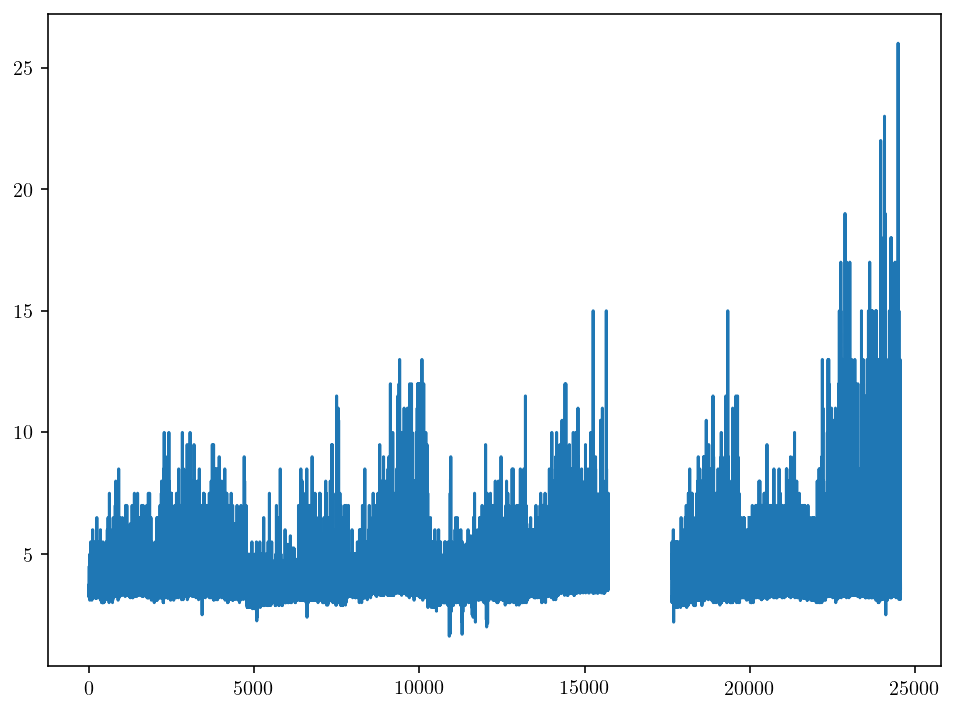

In [141]:
pd.Series(match_data["VCD"]).plot()



<AxesSubplot:>

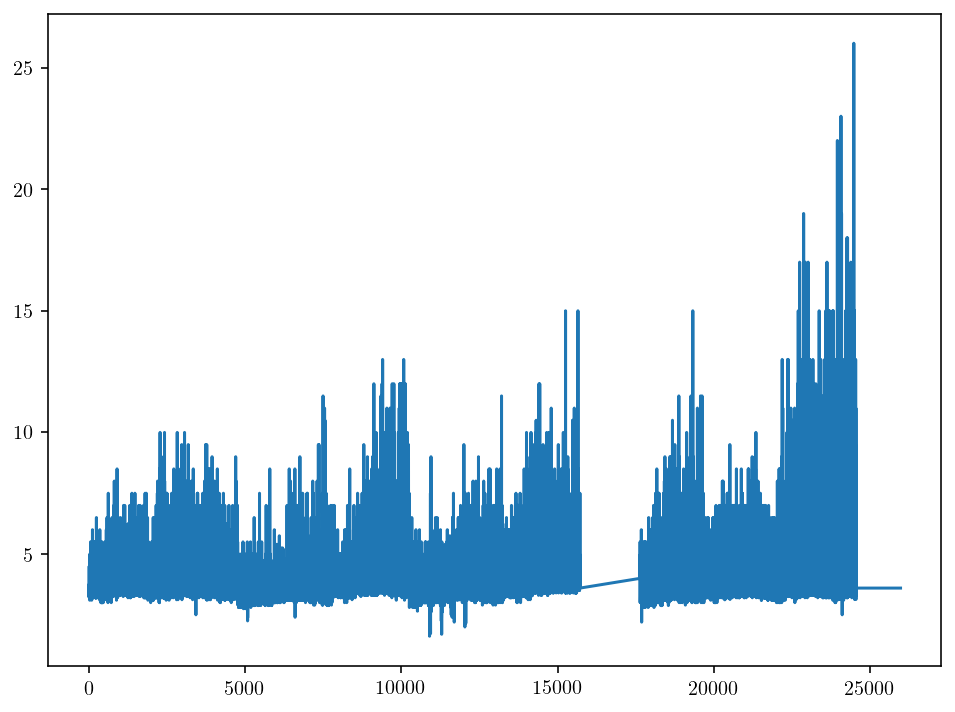

In [142]:
pd.Series(match_data["VCD"].interpolate()).plot()

In [144]:
match_data["VCD"].mean()

3.899048342786246

## GROUP BY AND MEAN


In [133]:
adf=players_all_data.groupby("year").mean()
adf

,id_x,player_fifa_api_id_x,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,id_y,player_fifa_api_id_y,height,weight
year,,,,,,,,,,,,,,,,,,,,,
2007,92144.544553,151320.148407,119976.425951,64.555967,72.195559,50.201402,47.042008,54.640306,57.218153,47.045666,...,46.437765,14.274899,19.510778,42.019413,19.530126,19.881249,5528.850477,151292.229706,181.919591,168.949188
2008,91700.387547,130967.647465,51154.655571,66.988440,74.100069,53.438233,49.218599,57.649931,59.902864,49.783588,...,48.196130,14.363527,24.797619,54.129227,24.819013,25.254313,5502.074164,130949.419110,182.106347,170.249914
2009,91904.132659,137225.128656,59709.713110,68.236707,75.166073,54.812013,49.826251,57.849499,61.200000,49.830131,...,48.083529,14.135373,25.218020,55.624027,25.230256,25.656507,5514.566218,137209.071611,182.189994,170.341154
2010,91242.966202,144666.449441,73179.963986,68.172041,74.916936,54.275247,48.824910,56.979303,61.240599,48.834055,...,47.015728,15.080292,19.604823,32.027626,19.657581,20.012011,5475.013021,144635.253024,182.116991,170.074430
2011,91751.333834,151537.136356,87284.571142,68.472343,73.963235,53.808740,47.747744,56.176972,61.205381,47.853526,...,46.474014,16.336397,16.042029,15.853192,16.089154,16.470003,5505.687709,151503.558951,182.174798,170.018370
2012,91816.149937,159621.585022,105619.126504,68.536079,73.038812,54.193743,48.169267,56.590495,61.826614,48.107406,...,47.021228,15.459960,15.142257,14.994535,15.223604,15.535287,5509.716434,159593.056444,182.030451,169.353467
2013,91798.692516,166632.574240,129118.401678,68.968736,73.383827,55.300541,49.794386,57.139866,62.743472,49.319341,...,47.659464,15.209348,14.906438,14.749730,14.986402,15.334046,5508.610029,166601.626779,181.949531,168.966192
2014,91746.045233,174496.249543,155395.993721,68.944255,72.971334,56.210783,50.930379,58.077153,63.403727,50.193340,...,49.036106,14.192974,13.935869,13.760551,13.962155,14.249177,5505.613113,174454.812028,181.769176,168.432120
2015,92769.365553,182858.958503,189252.057737,69.578258,73.398328,56.466874,51.359356,57.841505,64.178390,50.303727,...,48.791219,14.264379,14.020774,13.873342,14.114149,14.351468,5567.537350,182808.676132,181.615904,167.635201


In [134]:
adf.reset_index()

,year,id_x,player_fifa_api_id_x,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,...,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,id_y,player_fifa_api_id_y,height,weight
0,2007,92144.544553,151320.148407,119976.425951,64.555967,72.195559,50.201402,47.042008,54.640306,57.218153,...,46.437765,14.274899,19.510778,42.019413,19.530126,19.881249,5528.850477,151292.229706,181.919591,168.949188
1,2008,91700.387547,130967.647465,51154.655571,66.988440,74.100069,53.438233,49.218599,57.649931,59.902864,...,48.196130,14.363527,24.797619,54.129227,24.819013,25.254313,5502.074164,130949.419110,182.106347,170.249914
2,2009,91904.132659,137225.128656,59709.713110,68.236707,75.166073,54.812013,49.826251,57.849499,61.200000,...,48.083529,14.135373,25.218020,55.624027,25.230256,25.656507,5514.566218,137209.071611,182.189994,170.341154
3,2010,91242.966202,144666.449441,73179.963986,68.172041,74.916936,54.275247,48.824910,56.979303,61.240599,...,47.015728,15.080292,19.604823,32.027626,19.657581,20.012011,5475.013021,144635.253024,182.116991,170.074430
4,2011,91751.333834,151537.136356,87284.571142,68.472343,73.963235,53.808740,47.747744,56.176972,61.205381,...,46.474014,16.336397,16.042029,15.853192,16.089154,16.470003,5505.687709,151503.558951,182.174798,170.018370
5,2012,91816.149937,159621.585022,105619.126504,68.536079,73.038812,54.193743,48.169267,56.590495,61.826614,...,47.021228,15.459960,15.142257,14.994535,15.223604,15.535287,5509.716434,159593.056444,182.030451,169.353467
6,2013,91798.692516,166632.574240,129118.401678,68.968736,73.383827,55.300541,49.794386,57.139866,62.743472,...,47.659464,15.209348,14.906438,14.749730,14.986402,15.334046,5508.610029,166601.626779,181.949531,168.966192
7,2014,91746.045233,174496.249543,155395.993721,68.944255,72.971334,56.210783,50.930379,58.077153,63.403727,...,49.036106,14.192974,13.935869,13.760551,13.962155,14.249177,5505.613113,174454.812028,181.769176,168.432120
8,2015,92769.365553,182858.958503,189252.057737,69.578258,73.398328,56.466874,51.359356,57.841505,64.178390,...,48.791219,14.264379,14.020774,13.873342,14.114149,14.351468,5567.537350,182808.676132,181.615904,167.635201
9,2016,92247.974261,186076.738850,207025.932284,70.382466,73.812030,57.468081,52.426231,58.516243,65.361753,...,49.167471,14.117818,13.740956,13.735565,13.948149,14.096326,5536.749911,186039.930157,181.624498,167.258668


In [159]:
!conda info


     active environment : cosmoT
    active env location : /Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT
            shell level : 2
       user config file : /Users/marcoantoniomerchandmedina/.condarc
 populated config files : /Users/marcoantoniomerchandmedina/.condarc
          conda version : 4.13.0
    conda-build version : 3.21.5
         python version : 3.9.7.final.0
       virtual packages : __osx=10.16=0
                          __unix=0=0
                          __archspec=1=x86_64
       base environment : /Users/marcoantoniomerchandmedina/opt/anaconda3  (writable)
      conda av data dir : /Users/marcoantoniomerchandmedina/opt/anaconda3/etc/conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/osx-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/osx-64
                          https://repo.anaconda.com/pkgs/r/noarch
          pack